In [2]:
% matplotlib inline
import timeit
import math

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString

base1 = Polygon([
    (-32.1665052195, 244.951010361),
    (0.0, 0.0),
    (164.100332863, -6.72252704724),
    (258.444740993, 131.833417876),
    (81.6832775051, 124.859373939),
    (75.3190068965, 248.195464884),
    (-32.1665052195, 244.951010361),
])

base2 = Polygon([
    (-49.4396391714, 329.180218029),
    (-92.9129195885, 247.064021685),
    (-57.9893698290, 147.064434513),
    (10.0375541578, 123.960950894),
    (42.1257258497, 41.8152313633),
    (0.0, 0.0),
    (243.639444075, -12.0928970791),
    (165.344305147, 76.4704567905),
    (128.122025984, 171.451444998),
    (75.3190068965, 248.195464884),
    (11.3210810255, 302.371185501),
    (-16.9165100634, 338.309937796),
    (-49.4396391714, 329.180218029)
])

base3 = Polygon([
    (-1.51418765128, -3.10820900539),
    (264.175873958, -3.10820900539),
    (264.175873958, 263.865379471),
    (-1.51418765128, 263.865379471),
    (-1.51418765128, -3.10820900539)
])

base4 = Polygon([
    (7.47050042245, 4.59295220067),
    (65.2292094678, 301.087658634),
    (135.823187190, 337.026410929),
    (289.846411311, 369.114582620),
    (465.689592183, 347.294625870),
    (595.325805818, 225.359573441),
    (603.026967024, 88.0221985996),
    (440.019054829, -6.95878960841),
    (300.114626252, -74.9857135952),
    (7.47050042245, 4.59295220067),
])

base5 = Polygon([
    (9.73997200653, -0.429771980603),
    (32.7216291224, 291.150002677),
    (126.084611155, 396.003813268),
    (252.483725293, 434.785359651),
    (263.974553851, 351.476852606),
    (355.901182314, 253.804809863),
    (582.845046333, 207.841495632),
    (627.372006995, 46.9698958208),
    (465.064053614, 6.75199586810),
    (222.320300328, 146.078292133),
    (118.902843307, 35.4790672629),
    (9.73997200653, -0.429771980603)
])
series = [base1, base2, base3, base4, base5]

196470.54502015776


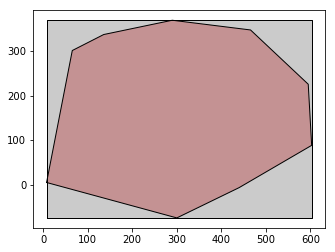

In [45]:
base = base4
print(base.area)
gpd.GeoSeries([base,base.envelope]).plot()

In [61]:
from shapely.ops import cascaded_union
import random
import copy

def get_corners(length, width, rotate_angle, center):
    if isinstance(center, Point):
        x = center.coords[0][0]
        y = center.coords[0][1]
    else:
        x = center[0]
        y = center[1]
    diagonal = math.sqrt(length ** 2 + width ** 2)
    r = diagonal / 2
    rotate_angle = math.radians(rotate_angle)
    original_angle = math.atan2(width, length)
    pointA_angle = -original_angle + rotate_angle
    pointB_angle = +original_angle + rotate_angle
    pointC_angle = math.pi - original_angle + rotate_angle
    pointD_angle = math.pi + original_angle + rotate_angle
    corners = [(r * math.cos(pointA_angle) + x, r * math.sin(pointA_angle) + y),
               (r * math.cos(pointB_angle) + x, r * math.sin(pointB_angle) + y),
               (r * math.cos(pointC_angle) + x, r * math.sin(pointC_angle) + y),
               (r * math.cos(pointD_angle) + x, r * math.sin(pointD_angle) + y)]
    return corners


def get_building(length, width, rotate_angle, center=(0, 0)):
    corners = get_corners(length, width, rotate_angle, center)
    return Polygon(corners)


def get_building_shadow(length, width, rotation_angle, center=(0, 0), h=80):
    shadow_list = []
    shadow_long = get_building(length=length + 26, width=width, rotate_angle=rotation_angle, center=center)
    shadow_height = get_building(length=length, width=2 * h, rotate_angle=rotation_angle, center=center)
    shadow_list.append(shadow_long)
    shadow_list.append(shadow_height)
    corners = get_corners(length, width, rotation_angle, center)
    for corner in corners:
        shadow_list.append(Point(corner).buffer(6, 4))
    shadow = cascaded_union(shadow_list)
    return shadow


def get_curve(pointA, pointB, pointC):
    if isinstance(pointA, Point):
        ax = pointA.x
        ay = pointA.y
    else:
        ax = pointA[0]
        ay = pointA[1]
    if isinstance(pointB, Point):
        bx = pointB.x
        by = pointB.y
    else:
        bx = pointB[0]
        by = pointB[1]
    if isinstance(pointC, Point):
        cx = pointC.x
        cy = pointC.y
    else:
        cx = pointC[0]
        cy = pointC[1]
        
    def bc(a, b, c, t):
        return (1-t)**2*a+2*t*(1-t)*b+t**2*c + 4*(1/4-(t-1/2)**2)*(-1/4*a+b/2-1/4*c)

    point_list = []
    for i in range(100):
        t = i / 100
        x = bc(ax, bx, cx, t)
        y = bc(ay, by, cy, t)
        point_list.append((x, y))
    return LineString(point_list)


def get_roads_v2(collection, base, max_distance):
    roads = []
    outside = base.symmetric_difference(base.envelope).buffer(-5)
    for i in range(len(collection) - 1):
        for j in range(i + 1, len(collection)):
            element1 = collection[i]
            element2 = collection[j]
            if element1.centroid.distance(element2.centroid) < max_distance:
                line = LineString([element1.centroid, element2.centroid])
                if not line.intersects(outside):
                    roads.append(line)
    return roads


def get_entrances(base, entrances_count=2, distance=100):
    coords = base.boundary.coords
    lines = []
    for i in range(len(coords)):
        line = LineString([coords[i % len(coords)], coords[(i + 1) % len(coords)]])
        lines.append(line)
    lines = sorted(lines, key=lambda line: line.length, reverse=True)
    entrances = [lines[0].centroid]
    for i in range(1, len(lines)):
        entrance = lines[i].centroid
        acceptable = True
        for other_entrance in entrances:
            if entrance.distance(other_entrance) < distance:
                acceptable = False
                break
        if acceptable:
            entrances.append(entrance)
        if len(entrances) >= entrances_count:
            break
    return [entrance.buffer(25) for entrance in entrances]


def get_buffered_sections(collection, buffer):
    new_collection_buffered = []
    for our_base in collection:
        buffered = our_base.buffer(buffer)
        if buffered.is_empty:
            continue
        elif isinstance(buffered, MultiPolygon):
            for geom in buffered:
                new_collection_buffered.append(geom)
        else:
            new_collection_buffered.append(buffered)
    return new_collection_buffered


def generate_plans(collection_buffered, overall_shadows, overall_buildings, fix_angle=None):
    # random.shuffle(collection_buffered)
    for our_base in collection_buffered:
        building_line = our_base
        if building_line.is_empty:
            continue
        building_line = building_line.boundary
        building_lines.append(building_line)
        building_coords = building_line.coords
        k = random.choice(range(len(building_coords)))
    
        for i in range(k, k + len(building_coords) - 1):
            start_point = building_coords[i % len(building_coords)]
            end_point = building_coords[(i + 1) % len(building_coords)]
            startx = start_point[0]
            starty = start_point[1]
            endx = end_point[0]
            endy = end_point[1]
            line = LineString([start_point, end_point])
            if line.length < 1:
                continue
            else:
                if not fix_angle:
                    angle = math.degrees(math.atan2(endy - starty, endx - startx))
                else:
                    angle = fix_angle
                if line.length<10:
                    n = 1
                else:
                    n = 10
                for j in range(n):
                    k = random.randint(0, 9)
                    center = (startx + ((j + k) % 10) * (endx - startx) / 10, starty + ((j + k) % 10) * (endy - starty) / 10)
                    building = get_building(32, 16, angle, center=center)
                    shadow = get_building_shadow(32, 16, angle, center=center)
                    if not overall_buildings:
                        if overall_shadows.intersects(building):
                            continue
                        else:
                            overall_buildings = building
                            overall_shadows = overall_shadows.union(shadow)
                    elif overall_shadows.intersects(building) or overall_buildings.intersects(shadow):
                        continue
                    else:
                        overall_shadows = overall_shadows.union(shadow)
                        overall_buildings = overall_buildings.union(building)
    return overall_buildings, overall_shadows

def generate_collection(min_r, max_r, density=20, resolution=4, entrace_collection=[]):
    envelope = base.envelope
    minx, miny, maxx, maxy = envelope.bounds
    x_diff = maxx - minx
    y_diff = maxy - miny
    point_list = []
    for j in range(density):
        for i in range(density):
            point = Point(minx + x_diff / density * i, miny + y_diff / density * j)
            if base.buffer(-15).contains(point):
                point_list.append(point)

    collection = copy.deepcopy(entrace_collection)
    max_iteration = 1000
    iter = 0
    while len(point_list) > 0 or iter > max_iteration:
        iter += 1
        first_point = random.choice(point_list)
        if len(collection) == 0:
            r = random.randint(min_r, max_r)
            circle = first_point.buffer(r, resolution)
            collection.append(circle)
            point_list.remove(first_point)
        else:
            distances = [first_point.distance(circle) for circle in collection]
            min_distance = min(distances)
            if min_distance < min_r:
                point_list.remove(first_point)
            elif min_distance > max_r:
                continue
            else:
                circle = first_point.buffer(min_distance+1, resolution)
                collection.append(circle)
                point_list.remove(first_point)
    return collection

def basic_curve(pointA, pointB, pointC):
    if isinstance(pointA, Point):
        ax = pointA.x
        ay = pointA.y
    else:
        ax = pointA[0]
        ay = pointA[1]
    if isinstance(pointB, Point):
        bx = pointB.x
        by = pointB.y
    else:
        bx = pointB[0]
        by = pointB[1]
    if isinstance(pointC, Point):
        cx = pointC.x
        cy = pointC.y
    else:
        cx = pointC[0]
        cy = pointC[1]

    def bc(a, b, c, t):
        return (1 - t) ** 2 * a + 2 * t * (1 - t) * b + t ** 2 * c

    point_list = []
    for i in range(8):
        t = i / 8
        x = bc(ax, bx, cx, t)
        y = bc(ay, by, cy, t)
        point_list.append((x, y))
    return point_list


def mod(i, module):
    return i % module


def smooth_polygon(polygon, min_length=20, multiple_start=True):
    coords = polygon.boundary.coords
    if multiple_start:
        coords = coords[:-1]
    tuple_list = []
    n = len(coords)
    for i in range(n):
        last_coord = coords[mod(n+i-1, n)]
        this_coord = coords[i]
        next_coord = coords[mod(n+i+1, n)]
        min_side_length = min(Point(next_coord).distance(Point(this_coord)), Point(last_coord).distance(Point(this_coord)))
        rate = min(0.5, min_length / min_side_length)
        s_point = (rate*last_coord[0]+(1-rate)*this_coord[0], rate*last_coord[1]+(1-rate)*this_coord[1])
        e_point = (rate*next_coord[0]+(1-rate)*this_coord[0], rate*next_coord[1]+(1-rate)*this_coord[1])
        curve = basic_curve(s_point, this_coord, e_point)
        tuple_list.extend(curve)
    return Polygon(tuple_list)

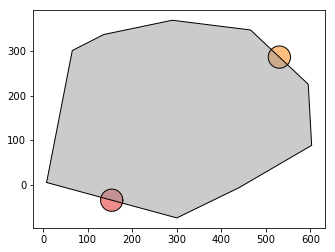

In [90]:
entrances = get_entrances(base, distance=400)
entrances.append(base)
gpd.GeoSeries(entrances).plot()

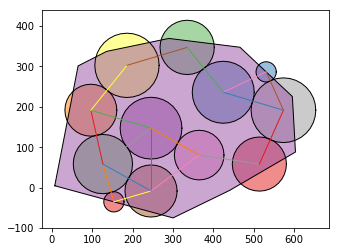

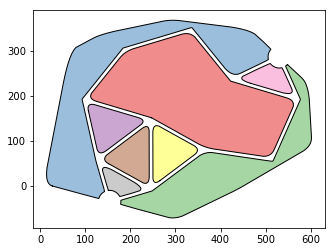

In [81]:
import random, copy, sys
from shapely.ops import cascaded_union
from shapely.geometry import *

max_coverage = 0
current_collection = []
def generate_divisions():
    entrances = get_entrances(base, distance=400)
    collection = generate_collection(60, 80, resolution=8, density=20, entrace_collection=entrances)
    coverage = sum([geom.intersection(base).area for geom in collection]) / base.area

    display = []
    display.extend(collection)
    display.append(base)
    roads = get_roads_v2(collection, base, 160)
    display.extend(roads)
    gpd.GeoSeries(display).plot()

    cascaded_entrances = cascaded_union(entrances)
    cascaded_roads = cascaded_union([road.buffer(4) for road in roads])
    cascaded_roads = cascaded_union([cascaded_roads, cascaded_entrances])
    place_to_build = base.difference(cascaded_roads)
    new_collection = []
    if isinstance(place_to_build, Polygon):
        new_collection = [place_to_build]
    else:
        for geom in place_to_build:
            new_collection.append(geom)
    new_collection = sorted(new_collection, key=lambda geom : geom.area, reverse=True)
    new_collection = [smooth_polygon(geom) for geom in new_collection]
    gpd.GeoSeries(new_collection).plot()
    return new_collection, cascaded_roads
new_collection, cascaded_roads = generate_divisions()

# new_collection2 = []
# new_collection_cascaded = cascaded_union(new_collection)
# for geom in collection:
#     geom = geom.intersection(new_collection_cascaded)
#     if isinstance(geom, Polygon):
#         new_collection2.append(geom)
#     else:
#         new_collection2.extend(geom)
# gpd.GeoSeries(new_collection2).plot()


# the_union = cascaded_union(current_collection)
# other_part = base.symmetric_difference(the_union)
# saved_collection = copy.deepcopy(current_collection)
# for part in other_part:
#     current_collection.append(part)


# roads, curve_roads = get_curve_roads(saved_collection)
# gpd.GeoSeries([roads, curve_roads, base]).plot()

# current_collection.append(base)

# new_collection2 = []
# for geom in saved_collection:
#     geom = geom.difference(roads)
#     if isinstance(geom, MultiPolygon):
#         for geo in geom:
#             new_collection2.append(geo)
#     else:
#         new_collection2.append(geom)
# 
# new_collection = [geom.intersection(base) for geom in new_collection2]
# gpd.GeoSeries(current_collection).plot()
# gpd.GeoSeries(new_collection2).plot()
# new_collection = sorted(new_collection, key=lambda geom : geom.area)

34


32


32


35


33


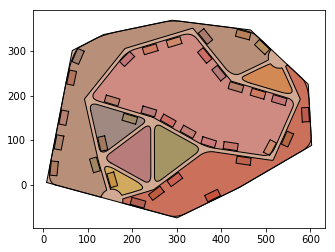

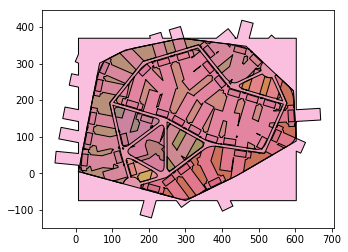

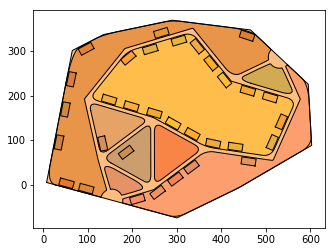

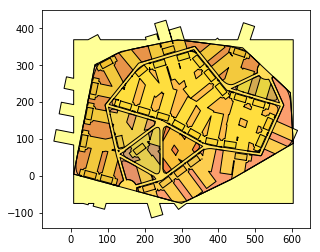

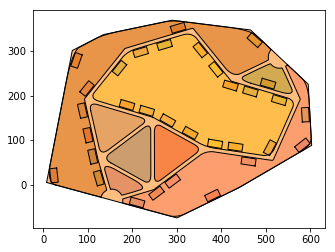

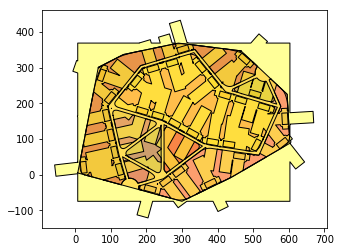

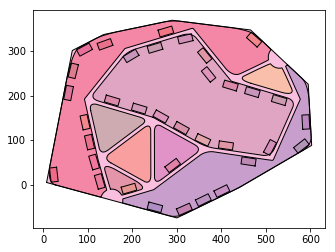

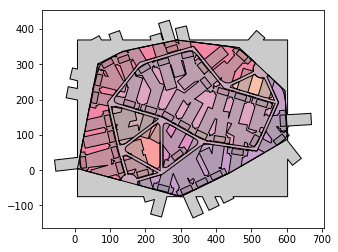

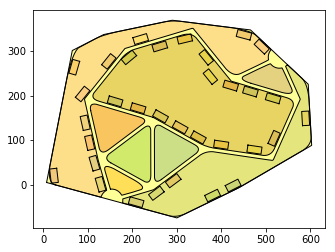

In [82]:
import random

for i in range(5):
    overall_buildings = None
    overall_shadows = cascaded_union([base.symmetric_difference(base.envelope), cascaded_roads])
    list_to_display = []
    building_lines = []
    for buffer in range(-10, -50, -10):
        new_collection_buffered = get_buffered_sections(new_collection, buffer)
        overall_buildings, overall_shadows = generate_plans(new_collection_buffered, overall_shadows, overall_buildings,
                                                            fix_angle=None)


    list_to_display.extend(overall_buildings)
    list_to_display.extend(new_collection)
    list_to_display.append(base)
    # list_to_display.append(cascaded_roads)
    # list_to_display.extend(building_lines)
    if len(overall_buildings) >= 0:
        gpd.GeoSeries(list_to_display).plot()
        list_to_display.append(overall_shadows)
        gpd.GeoSeries(list_to_display).plot()
        print(len(overall_buildings))
plt.show()

(2.241150126735, -22.49571407856, 180.9080901072, 110.734374786) 17682.349051814203 (2.241150126735, -22.49571407856, 180.9080901072, 110.734374786)


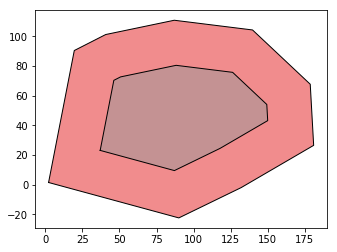

In [33]:
from shapely.affinity import *
our_base = scale(base4, xfact=0.3, yfact=0.3, origin=(0, 0))
print(our_base.bounds, our_base.area, our_base.envelope.bounds)
gpd.GeoSeries([our_base, our_base.buffer(-30)]).plot()

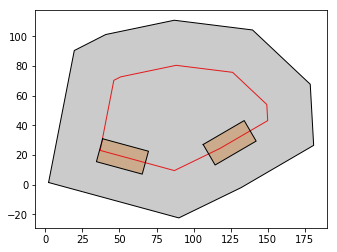

In [34]:
import random
building_line = our_base.buffer(-30).boundary
building_vertical_line = our_base.buffer(-30).boundary
building_coords = building_line.coords
building_point_list = []
k = random.choice(range(len(building_coords)))

shadows = None
buildings = None
for i in range(k, k + len(building_coords) - 1):
    start_point = building_coords[i % len(building_coords)]
    end_point = building_coords[(i + 1) % len(building_coords)]
    startx = start_point[0]
    starty = start_point[1]
    endx = end_point[0]
    endy = end_point[1]
    line = LineString([start_point, end_point])
    if line.length < 0:
        continue
    else:
        angle = math.degrees(math.atan2(endy - starty, endx - startx))
        for j in range(10):
            k = random.randint(0, 9)
            center = (startx + ((j + k) % 10) * (endx - startx) / 10, starty + ((j + k) % 10) * (endy - starty) / 10)
            building = get_building(32, 16, angle, center=center)
            shadow = get_building_shadow(32, 16, angle, center=center)
            if not shadows:
                shadows = shadow
                buildings = building
            elif shadows.intersects(building) or buildings.intersects(shadow):
                continue
            else:
                shadows = shadows.union(shadow)
                buildings = buildings.union(building)

gpd.GeoSeries([building_line, buildings, our_base]).plot()